# Denoising Autoencoders And Where To Find Them


非监督学习的一种： 自编码机。

主要思想： 将图片（或其他输入，如语音，文字）编码，然后解码恢复，如果恢复损失越小，表示编码越正确，信息损失越少。

没有标签，自训练的一种。 

编码可以用来做很多事情，最大的作用是降维（例如PCA）。一些应用方面：

1. 图像去噪（去除无用信息）
2. 找相似图像（或文本）
3. 图像渐变。



## 0. Import and  Constants

In [1]:
import tensorflow as tf
import keras
import keras.layers as L
import keras.backend as K

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


def reset_tf_session():
    K.clear_session()
    tf.reset_default_graph()
    s = K.get_session()
    return s


/home/yangdong/Applications/miniconda3/envs/DL3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 1. 数据集
Dataset was downloaded for you. Relevant links (just in case):
- http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
- http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
- http://vis-www.cs.umass.edu/lfw/lfw.tgz


共  13233 个图像， 每个图片的路径是这样子的： `'lfw/George_HW_Bush/George_HW_Bush_0001.jpg'`

In [2]:
import os

ATTRS_NAME = "lfw_attributes.txt"  # http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
IMAGES_NAME = "lfw-deepfunneled.tgz"  # http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
RAW_IMAGES_NAME = "lfw.tgz"  # http://vis-www.cs.umass.edu/lfw/lfw.tgz

data_path = '../readonly/week4'

ATTRS_NAME = os.path.join(data_path, ATTRS_NAME)
IMAGES_NAME = os.path.join(data_path, IMAGES_NAME)
RAW_IMAGES_NAME = os.path.join(data_path, RAW_IMAGES_NAME)


In [3]:
import tarfile

with tarfile.open(RAW_IMAGES_NAME) as f:
    all_files = [m.name for m in f.getmembers() if m.isfile()]

lfw/George_HW_Bush/George_HW_Bush_0001.jpg


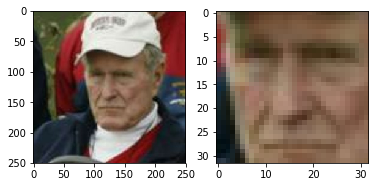

In [4]:
import cv2

def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def get_image_data(raw_bytes, crop=80, resize_shape=(32, 32)):
    img = decode_image_from_raw_bytes(raw_bytes)
    dx = dy = crop
    img = img[dy:-dy, dx:-dx]
    img = cv2.resize(img, resize_shape)
    return img

with tarfile.open(RAW_IMAGES_NAME) as f:
    for m in f.getmembers():
        if m.isfile() and m.name.endswith(".jpg"):
            print(m.name)
            raw_bytes = f.extractfile(m).read()
            break
            
fig = plt.figure()

img = decode_image_from_raw_bytes(raw_bytes)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(img)

img = get_image_data(raw_bytes)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(img)
plt.show()


In [5]:
os.path.split(all_files[0])[-1]

'George_HW_Bush_0001.jpg'

In [6]:
import pandas as pd
# read attrs
df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))
print(len(imgs_with_attrs))

13143


lfw_attributes.txt 里面只有13143个头像的特征

In [7]:
# 存储所有图片
photo_ids = []
all_photos = []

with tarfile.open(RAW_IMAGES_NAME) as f:
    for m in f.getmembers():
        if m.isfile() and m.name.endswith(".jpg"):
            # prepare image
            raw_bytes = f.extractfile(m).read()
            img = get_image_data(raw_bytes, resize_shape=(32, 32))
            # parse person
            fname = os.path.split(m.name)[-1]
            fname_splitted = fname[:-4].replace('_', ' ').split()
            person_id = ' '.join(fname_splitted[:-1])
            photo_number = int(fname_splitted[-1])
            if (person_id, photo_number) in imgs_with_attrs:
                all_photos.append(img)
                photo_ids.append({'person': person_id, 'imagenum': photo_number})

photo_ids = pd.DataFrame(photo_ids)
all_photos = np.stack(all_photos).astype('uint8')

In [8]:
print(all_photos.shape)

(13143, 32, 32, 3)


In [9]:
from sklearn.model_selection import train_test_split

X = all_photos
IMG_SHAPE = X.shape[1:]

# center images
X = X.astype('float32') / 255.0 - 0.5

# split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

X shape: (13143, 32, 32, 3)


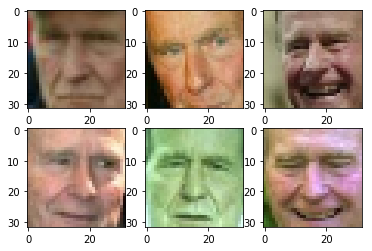

In [13]:
plt.title('sample images')

def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

for i in range(6):
    plt.subplot(2,3,i+1)
    show_image(X[i])

print("X shape:", X.shape)


##  2. Autoencoder architecture

Let's design autoencoder as two sequential keras models: the encoder and decoder respectively.

We will then use symbolic API to apply and train these models.

<img src="images/autoencoder.png" style="width:50%">

### 2.1 PCA

PCA 应该是最早学的降维手段了。 其原理就是找到数据集 $X$ 的协方差矩阵的特征向量。

也可以用神经网络训练。

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

<img src="images/pca.png" style="width:30%">


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [11]:
import keras.models
import keras.layers as L

def build_pca_autoencoder(img_shape, code_size):
    
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Flatten())                  #flatten image to vector
    encoder.add(L.Dense(code_size))           #actual encoder

    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(np.prod(img_shape)))  #actual decoder, height*width*3 units
    decoder.add(L.Reshape(img_shape))         #un-flatten
    
    return encoder,decoder

In [12]:
s = reset_tf_session()

encoder, decoder = build_pca_autoencoder(IMG_SHAPE, code_size=32)

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

autoencoder.fit(x=X_train, y=X_train, epochs=15,
                validation_data=[X_test, X_test],
                verbose=1)

Train on 11828 samples, validate on 1315 samples
Epoch 1/15
11828/11828 [==============================] - 1s 53us/step - loss: 0.0125 - val_loss: 0.0085
Epoch 2/15
11828/11828 [==============================] - 0s 41us/step - loss: 0.0077 - val_loss: 0.0070
Epoch 3/15
11828/11828 [==============================] - 0s 42us/step - loss: 0.0069 - val_loss: 0.0067
Epoch 4/15
11828/11828 [==============================] - 0s 41us/step - loss: 0.0067 - val_loss: 0.0066
Epoch 5/15
11828/11828 [==============================] - 0s 41us/step - loss: 0.0067 - val_loss: 0.0066
Epoch 6/15
11828/11828 [==============================] - 0s 41us/step - loss: 0.0067 - val_loss: 0.0066
Epoch 7/15
11828/11828 [==============================] - 0s 41us/step - loss: 0.0067 - val_loss: 0.0067
Epoch 8/15
11828/11828 [==============================] - 0s 41us/step - loss: 0.0067 - val_loss: 0.0066
Epoch 9/15
11828/11828 [==============================] - 0s 41us/step - loss: 0.0067 - val_loss: 0.0066
Epoch 

In [14]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()


PCA MSE: 0.0065787276554102


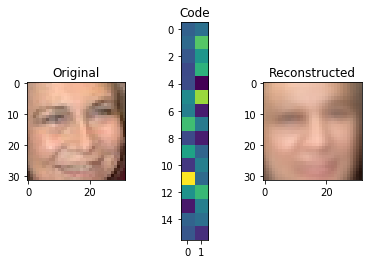

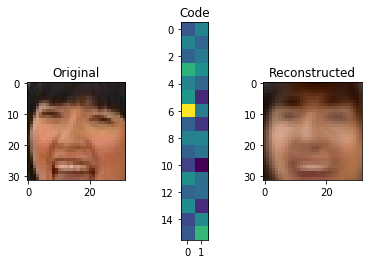

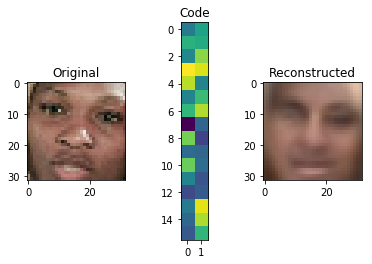

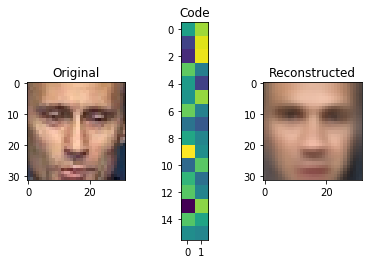

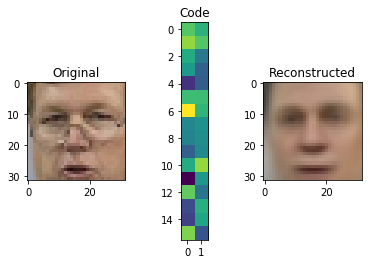

In [15]:
score = autoencoder.evaluate(X_test,X_test,verbose=0)
print("PCA MSE:", score)

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

### 2.2  Going deeper: convolutional autoencoder

可以用更复杂的 CONV 网络来实现 自编码器。 主要注意一个： transpose convolution


Here's how "transpose convolution" works:
<img src="images/transpose_conv.jpg" style="width:60%">
In this example we use a stride of 2 to produce 4x4 output, this way we "undo" pooling as well. Another way to think about it: we "undo" convolution with stride 2 (which is similar to conv + pool).

You can add "transpose convolution" layer in Keras like this:
```python
L.Conv2DTranspose(filters=?, kernel_size=(3, 3), strides=2, activation='elu', padding='same')
```

Our decoder starts with a dense layer to "undo" the last layer of encoder. Remember to reshape its output to "undo" `L.Flatten()` in encoder.


下面这个例子显示 `conv2d_transpose` 是如何工作的。定义好输出的形状，用filter计算然后叠加

In [35]:
# Let's play around with transpose convolution on examples first
def test_conv2d_transpose(img_size, filter_size):
    print("Transpose convolution test for img_size={}, filter_size={}:".format(img_size, filter_size))
    
    x = (np.arange(img_size ** 2, dtype=np.float32) + 1).reshape((1, img_size, img_size, 1))
    f = (np.ones(filter_size ** 2, dtype=np.float32)).reshape((filter_size, filter_size, 1, 1))

    conv = tf.nn.conv2d_transpose(x, f, 
                                  output_shape=(1, img_size * 2, img_size * 2, 1), 
                                  strides=[1, 2, 2, 1], 
                                  padding='SAME')

    with tf.Session() as session:
        result = session.run(conv)
        print("input:")
        print(x[0, :, :, 0])
        print("filter:")
        print(f[:, :, 0, 0])
        print("output:")
        print(result[0, :, :, 0])
        
test_conv2d_transpose(img_size=2, filter_size=2)
test_conv2d_transpose(img_size=2, filter_size=3)
test_conv2d_transpose(img_size=4, filter_size=2)
test_conv2d_transpose(img_size=4, filter_size=3)

Transpose convolution test for img_size=2, filter_size=2:
input:
[[1. 2.]
 [3. 4.]]
filter:
[[1. 1.]
 [1. 1.]]
output:
[[1. 1. 2. 2.]
 [1. 1. 2. 2.]
 [3. 3. 4. 4.]
 [3. 3. 4. 4.]]
Transpose convolution test for img_size=2, filter_size=3:
input:
[[1. 2.]
 [3. 4.]]
filter:
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
output:
[[ 1.  1.  3.  2.]
 [ 1.  1.  3.  2.]
 [ 4.  4. 10.  6.]
 [ 3.  3.  7.  4.]]
Transpose convolution test for img_size=4, filter_size=2:
input:
[[ 1.  2.  3.  4.]
 [ 5.  6.  7.  8.]
 [ 9. 10. 11. 12.]
 [13. 14. 15. 16.]]
filter:
[[1. 1.]
 [1. 1.]]
output:
[[ 1.  1.  2.  2.  3.  3.  4.  4.]
 [ 1.  1.  2.  2.  3.  3.  4.  4.]
 [ 5.  5.  6.  6.  7.  7.  8.  8.]
 [ 5.  5.  6.  6.  7.  7.  8.  8.]
 [ 9.  9. 10. 10. 11. 11. 12. 12.]
 [ 9.  9. 10. 10. 11. 11. 12. 12.]
 [13. 13. 14. 14. 15. 15. 16. 16.]
 [13. 13. 14. 14. 15. 15. 16. 16.]]
Transpose convolution test for img_size=4, filter_size=3:
input:
[[ 1.  2.  3.  4.]
 [ 5.  6.  7.  8.]
 [ 9. 10. 11. 12.]
 [13. 14. 15. 16.]]
filter

In [17]:
def build_deep_autoencoder(img_shape, code_size):
    """PCA's deeper brother. See instructions above. Use `code_size` in layer definitions."""
    H,W,C = img_shape
    
    # encoder
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    
    ### YOUR CODE HERE: define encoder as per instructions above ###
    encoder.add(L.Conv2D(32, (3, 3), strides=(2, 2), activation='elu', padding='same'))
    encoder.add(L.Conv2D(64, (3, 3), strides=(2, 2), activation='elu', padding='same'))
    encoder.add(L.Conv2D(128, (3, 3), strides=(2, 2), activation='elu', padding='same'))
    encoder.add(L.Conv2D(256, (3, 3), strides=(2, 2), activation='elu', padding='same'))
    encoder.add(L.Flatten())                  #flatten image to vector
    encoder.add(L.Dense(code_size, activation='elu'))           #actual encoder

    # decoder
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(np.prod((2, 2, 256))))  #actual decoder, height*width*3 units
    decoder.add(L.Reshape((2, 2, 256)))         #un-flatten
    decoder.add(L.Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same'))
    
    return encoder, decoder

In [18]:
s = reset_tf_session()
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)

encoder.summary()
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 256)         295168    
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                32800     
Total para

Convolutional autoencoder training. This will take **1 hour**. You're aiming at ~0.0056 validation MSE and ~0.0054 training MSE.

In [19]:
s = reset_tf_session()

encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

In [20]:
# we will save model checkpoints here to continue training in case of kernel death
model_filename = 'autoencoder.{0:03d}.hdf5'
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
#### fill `last_finished_epoch` with your latest finished epoch
# from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 4
# autoencoder = load_model(model_filename.format(last_finished_epoch))
# encoder = autoencoder.layers[1]
# decoder = autoencoder.layers[2]

In [21]:
autoencoder.fit(x=X_train, y=X_train, epochs=100,
                validation_data=[X_test, X_test],
#                 callbacks=[keras_utils.ModelSaveCallback(model_filename),
#                            keras_utils.TqdmProgressCallback()],
                verbose=1,
                initial_epoch=last_finished_epoch or 0)

Train on 11828 samples, validate on 1315 samples
Epoch 1/100
11828/11828 [==============================] - 2s 188us/step - loss: 0.0112 - val_loss: 0.0074
Epoch 2/100
11828/11828 [==============================] - 2s 132us/step - loss: 0.0072 - val_loss: 0.0069
Epoch 3/100
11828/11828 [==============================] - 2s 135us/step - loss: 0.0070 - val_loss: 0.0069
Epoch 4/100
11828/11828 [==============================] - 2s 135us/step - loss: 0.0069 - val_loss: 0.0067
Epoch 5/100
11828/11828 [==============================] - 2s 135us/step - loss: 0.0068 - val_loss: 0.0067
Epoch 6/100
11828/11828 [==============================] - 2s 135us/step - loss: 0.0067 - val_loss: 0.0067
Epoch 7/100
11828/11828 [==============================] - 2s 135us/step - loss: 0.0067 - val_loss: 0.0066
Epoch 8/100
11828/11828 [==============================] - 2s 135us/step - loss: 0.0067 - val_loss: 0.0065
Epoch 9/100
11828/11828 [==============================] - 2s 135us/step - loss: 0.0066 - val_l

11828/11828 [==============================] - 2s 146us/step - loss: 0.0049 - val_loss: 0.0055
Epoch 77/100
11828/11828 [==============================] - 2s 146us/step - loss: 0.0049 - val_loss: 0.0056
Epoch 78/100
11828/11828 [==============================] - 2s 146us/step - loss: 0.0049 - val_loss: 0.0055
Epoch 79/100
11828/11828 [==============================] - 2s 146us/step - loss: 0.0049 - val_loss: 0.0056
Epoch 80/100
11828/11828 [==============================] - 2s 146us/step - loss: 0.0049 - val_loss: 0.0055
Epoch 81/100
11828/11828 [==============================] - 2s 146us/step - loss: 0.0048 - val_loss: 0.0055
Epoch 82/100
11828/11828 [==============================] - 2s 146us/step - loss: 0.0048 - val_loss: 0.0055
Epoch 83/100
11828/11828 [==============================] - 2s 146us/step - loss: 0.0048 - val_loss: 0.0055
Epoch 84/100
11828/11828 [==============================] - 2s 146us/step - loss: 0.0048 - val_loss: 0.0056
Epoch 85/100
11828/11828 [===============

Convolutional autoencoder MSE: 0.005570850497423299


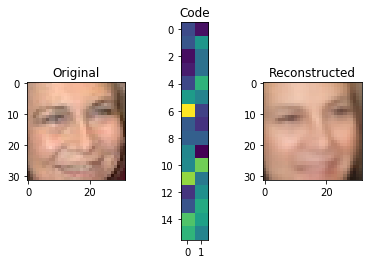

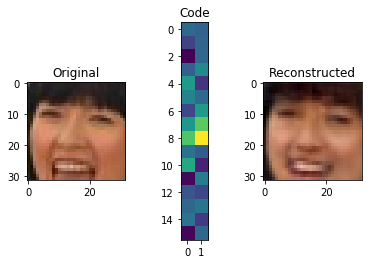

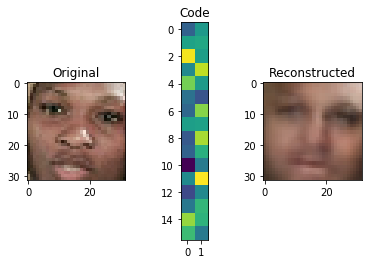

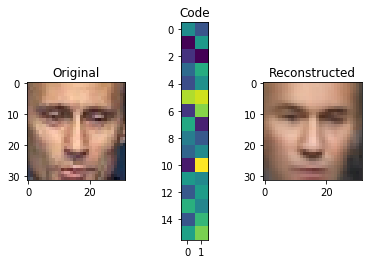

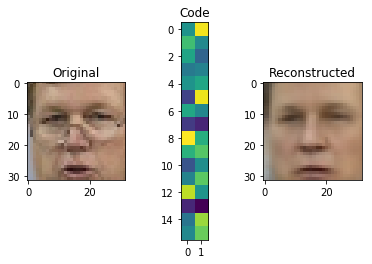

In [22]:
reconstruction_mse = autoencoder.evaluate(X_test, X_test, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [23]:
# save trained weights
encoder.save_weights("encoder.h5")
decoder.save_weights("decoder.h5")

In [24]:
# restore trained weights
s = reset_tf_session()

encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")
decoder.load_weights("decoder.h5")

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

print(autoencoder.evaluate(X_test, X_test, verbose=0))
print(reconstruction_mse)

0.005570850497423299
0.005570850497423299


## 3. Denoising Autoencoder

This part is **optional**, it shows you one useful application of autoencoders: denoising. You can run this code and make sure denoising works :) 

Let's now turn our model into a denoising autoencoder:
<img src="images/denoising.jpg" style="width:40%">

We'll keep the model architecture, but change the way it is trained. In particular, we'll corrupt its input data randomly with noise before each epoch.

There are many strategies to introduce noise: adding gaussian white noise, occluding with random black rectangles, etc. We will add gaussian white noise.

In [26]:
def apply_gaussian_noise(X,sigma=0.1):
    """
    adds noise from standard normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    Returns X + noise.
    """
    noise = np.random.randn(*X.shape) * sigma
    return X + noise

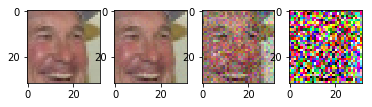

In [27]:
# test different noise scales
plt.subplot(1,4,1)
show_image(X_train[0])
plt.subplot(1,4,2)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.01)[0])
plt.subplot(1,4,3)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.1)[0])
plt.subplot(1,4,4)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.5)[0])

Training will take **1 hour**. 用 code_size = 512 很容易使 MSE到达 0.005以下， 0.0022的水平。

之前 的code_size = 32就下降比较困难。 

如果以此为评分标准的话，增大code_size就可以了

In [29]:
s = reset_tf_session()

# we use bigger code size here for better quality
# encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=512)
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=512)
# assert encoder.output_shape[1:]==(512,), "encoder must output a code of required size"

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp, reconstruction)
autoencoder.compile('adamax', 'mse')

for i in range(50):
    print("Epoch %i/25, Generating corrupted samples..."%(i+1))
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)
    
    # we continue to train our model with new noise-augmented data
    autoencoder.fit(x=X_train_noise, y=X_train, epochs=1,
                    validation_data=[X_test_noise, X_test],
#                     callbacks=[keras_utils.TqdmProgressCallback()],
                    verbose=1)

Epoch 1/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1
11828/11828 [==============================] - 2s 163us/step - loss: 0.0090 - val_loss: 0.0054
Epoch 2/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1
11828/11828 [==============================] - 2s 144us/step - loss: 0.0047 - val_loss: 0.0041
Epoch 3/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1
11828/11828 [==============================] - 2s 144us/step - loss: 0.0039 - val_loss: 0.0037
Epoch 4/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1
11828/11828 [==============================] - 2s 144us/step - loss: 0.0035 - val_loss: 0.0034
Epoch 5/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1
11828/11828 [==============================] - 2s 144us/step - loss: 0.0032 - val_loss: 0.0031
Epoch 6/25

Train on 11828 samples, validate on 1315 samples
Epoch 1/1
11828/11828 [==============================] - 2s 146us/step - loss: 0.0020 - val_loss: 0.0020
Epoch 43/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1
11828/11828 [==============================] - 2s 145us/step - loss: 0.0020 - val_loss: 0.0020
Epoch 44/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1
11828/11828 [==============================] - 2s 145us/step - loss: 0.0019 - val_loss: 0.0020
Epoch 45/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1
11828/11828 [==============================] - 2s 145us/step - loss: 0.0019 - val_loss: 0.0020
Epoch 46/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1
11828/11828 [==============================] - 2s 145us/step - loss: 0.0019 - val_loss: 0.0020
Epoch 47/25, Generating corrupted samples...
Train

Denoising MSE: 0.002001269492356128


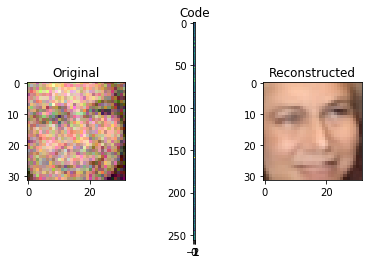

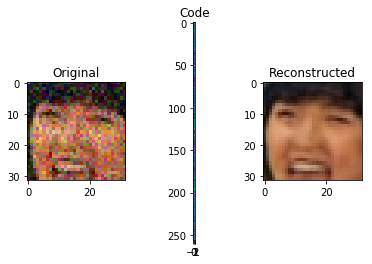

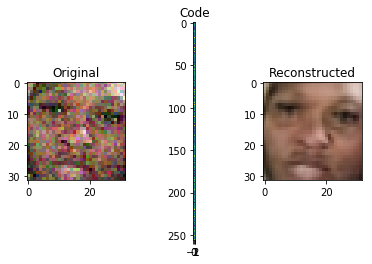

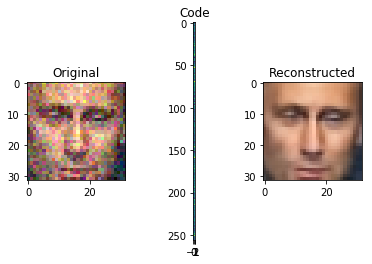

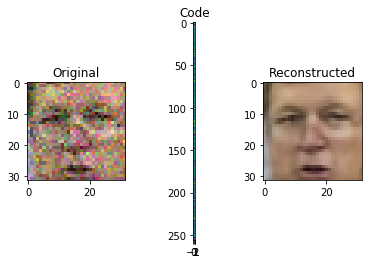

In [30]:
X_test_noise = apply_gaussian_noise(X_test)
denoising_mse = autoencoder.evaluate(X_test_noise, X_test, verbose=0)
print("Denoising MSE:", denoising_mse)
for i in range(5):
    img = X_test_noise[i]
    visualize(img,encoder,decoder)

## 4. Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see them in action.

First thing we can do is image retrieval aka image search. We will give it an image and find similar images in latent space:

<img src="images/similar_images.jpg" style="width:60%">

To speed up retrieval process, one should use Locality Sensitive Hashing on top of encoded vectors. This [technique](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) can narrow down the potential nearest neighbours of our image in latent space (encoder code). We will caclulate nearest neighbours in brute force way for simplicity.

In [31]:
# restore trained encoder weights
s = reset_tf_session()
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")

In [32]:
images = X_train
codes = encoder.predict(images)
assert len(codes) == len(images)

In [33]:
from sklearn.neighbors.unsupervised import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(codes)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [34]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encoder.predict(image[None])
    
    (distances,),(idx,) = nei_clf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances, images[idx]

In [35]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=3)
    
    plt.figure(figsize=[8,7])
    plt.subplot(1,4,1)
    show_image(image)
    plt.title("Original image")
    
    for i in range(3):
        plt.subplot(1,4,i+2)
        show_image(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

Cherry-picked examples:

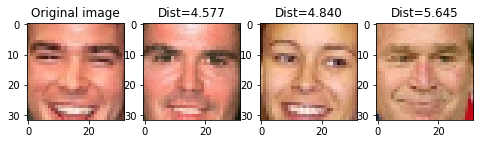

In [36]:
# smiles
show_similar(X_test[247])

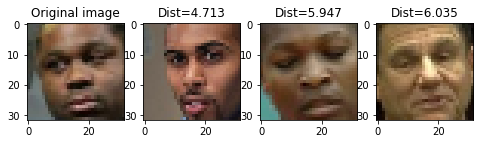

In [37]:
# ethnicity
show_similar(X_test[56])

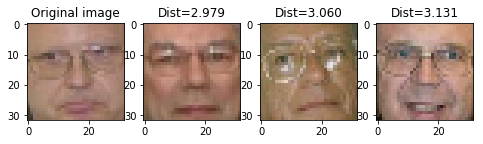

In [38]:
# glasses
show_similar(X_test[63])

## 5. Cheap image morphing


We can take linear combinations of image codes to produce new images with decoder.

In [39]:
# restore trained encoder weights
s = reset_tf_session()
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")
decoder.load_weights("decoder.h5")

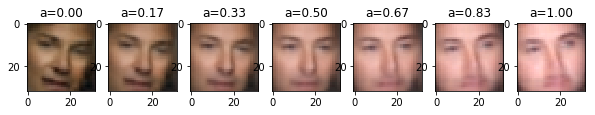

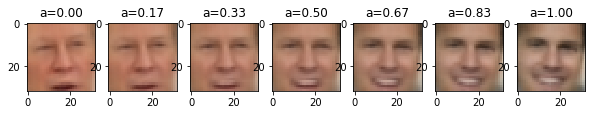

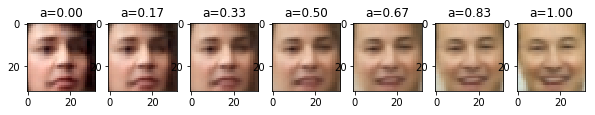

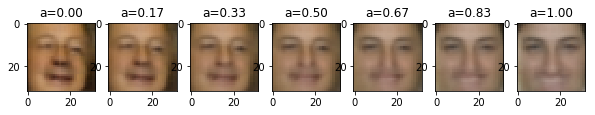

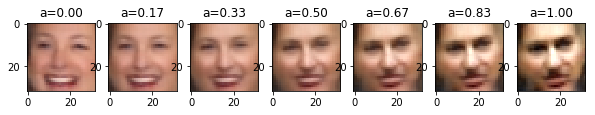

In [40]:
for _ in range(5):
    image1,image2 = X_test[np.random.randint(0,len(X_test),size=2)]

    code1, code2 = encoder.predict(np.stack([image1, image2]))

    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_image = decoder.predict(output_code[None])[0]

        plt.subplot(1,7,i+1)
        show_image(output_image)
        plt.title("a=%.2f"%a)
        
    plt.show()

That's it!

Of course there's a lot more you can do with autoencoders.

If you want to generate images from scratch, however, we recommend you our honor track on Generative Adversarial Networks or GANs.